In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/input_model_potenc_predXfault7_A.csv")

# Drop columns with more than 40% missing values
threshold = 0.4
df = df.dropna(thresh=int((1 - threshold) * len(df)), axis=1)

# Convert timestamp to datetime and extract time features
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df = df.drop(columns=['timestamp'])

# Fill remaining missing values
df = df.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-3-490869949.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Separate features and target
X = df.drop(columns=['fault_d7'])
y = df['fault_d7']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_pred = rf.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9776887871853547
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96       452
           1       0.97      1.00      0.99      1296

    accuracy                           0.98      1748
   macro avg       0.98      0.96      0.97      1748
weighted avg       0.98      0.98      0.98      1748

Confusion Matrix:
 [[ 416   36]
 [   3 1293]]


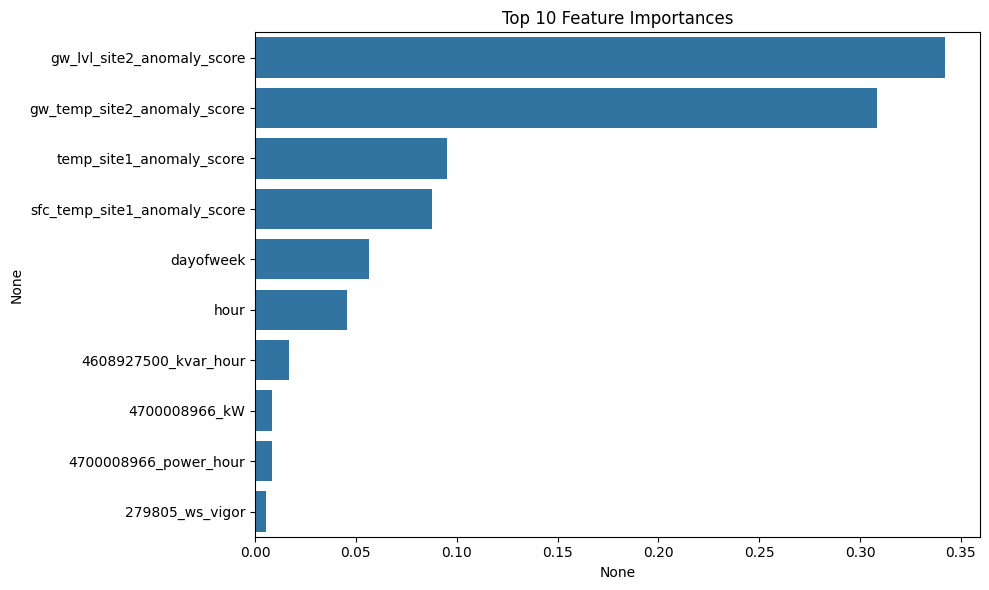

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
importances = rf.feature_importances_
features = X.columns
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10])
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [ ]:
# Define time window size
n_steps = 24  # 1 day of hourly data

# Scale features again (important for DL)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape using sliding window
X_lstm, y_lstm = [], []

for i in range(n_steps, len(X_scaled)):
    X_lstm.append(X_scaled[i-n_steps:i])
    y_lstm.append(y.iloc[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

print("LSTM Input Shape:", X_lstm.shape)

LSTM Input Shape: (8713, 24, 18)


In [ ]:
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,697 (131.63 KB)

 Trainable params: 33,697 (131.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7118 - loss: 0.5492 - val_accuracy: 0.8572 - val_loss: 0.3563
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8212 - loss: 0.3698 - val_accuracy: 0.7604 - val_loss: 0.5416
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8633 - loss: 0.2908 - val_accuracy: 0.7582 - val_loss: 0.6692
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9031 - loss: 0.2204 - val_accuracy: 0.7841 - val_loss: 0.7453
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9199 - loss: 0.1767 - val_accuracy: 0.7418 - val_loss: 0.9068
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9314 - loss: 0.1502 - val_accuracy: 0.7088 - val_loss: 1.1131


In [ ]:
# Predict and convert probabilities to binary
y_pred_probs = model.predict(X_test_lstm)
y_pred_lstm = (y_pred_probs > 0.5).astype(int)

# Accuracy and report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("LSTM Accuracy:", accuracy_score(y_test_lstm, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test_lstm, y_pred_lstm))
print("Confusion Matrix:\n", confusion_matrix(y_test_lstm, y_pred_lstm))

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM Accuracy: 0.8605851979345955
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       192
           1       0.89      0.97      0.93      1551

    accuracy                           0.86      1743
   macro avg       0.44      0.48      0.46      1743
weighted avg       0.79      0.86      0.82      1743

Confusion Matrix:
 [[   0  192]
 [  51 1500]]
